In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import os.path
from os.path import join
import numpy as np
import imodelsx
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import data
import imodelsx.viz
import joblib
import dvu
import theme_classification
files_dict = data.load_files_dict_single_site()

[2024-01-22 10:02:23,170] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


success: 18
fail: ['Cincinnati', 'Columbus']


### Filter data for single-site analysis

In [ ]:
checkpoint = 'gpt-4'
# checkpoint = 'gpt-35-turbo'
# checkpoint = 'mistralai/Mistral-7B-v0.1' # did very poorly

# site = 'Atlanta'
# site = 'Columbus'
site = 'WashingtonDC'
df = files_dict[site]

qs, responses_df, themes_df = data.split_single_site_df(df)

In [ ]:
question, responses, theme_dict = data.get_data_for_question_single_site(
    question_num=8, qs=qs, responses_df=responses_df, themes_df=themes_df)

In [ ]:
llm = imodelsx.llm.get_llm(checkpoint, repeat_delay=None)

# example
# response = responses[1]
# if len(theme_dict) > 1:
#     assert not pd.isna(response)
#     prompt = classification_prompt.format(
#         question=question,
#         classes_as_numbered_list=numbered_list(theme_dict.keys()),
#         response=response,
#     )
#     print(prompt)
# llm(prompt)

In [ ]:
valid_question_nums = theme_classification.get_valid_question_nums(
    qs, responses_df, themes_df)

### Run classification
Note: this uses a lot of calls, num valid questions * num responses = 250

In [25]:
# llm = imodelsx.llm.get_llm(checkpoint, repeat_delay=None)
# valid_question_nums = theme_classification.get_valid_question_nums(
#     qs, responses_df, themes_df)
# classifications = theme_classification.get_classifications(
#     llm, valid_question_nums, qs, responses_df, themes_df)


# iterative version
# ['Atlanta', 'Columbus', 'WashingtonDC']:
# for site in ['Charlotte', 'Houston', 'Portland']:
# Dallas not running for some reason...
for site in ['Dallas', 'Seattle', 'Tucson']:
    df = files_dict[site]
    qs, responses_df, themes_df = data.split_single_site_df(df)
    valid_question_nums = theme_classification.get_valid_question_nums(
        qs, responses_df, themes_df)
    classifications = theme_classification.get_classifications(
        llm, valid_question_nums, qs, responses_df, themes_df)
    theme_classification.compute_and_save_eval_mat(classifications, valid_question_nums,
                                                   qs, responses_df, themes_df, site, checkpoint)

100%|██████████| 46/46 [00:00<00:00, 4251.61it/s]


num valid qs 16


100%|██████████| 46/46 [00:00<00:00, 5142.82it/s]


num valid qs 7


100%|██████████| 7/7 [01:41<00:00, 14.46s/it]


### Make aggregated heatmap

gpt-4 num questions 261.0
gpt-4 num on diagonal 108.0
gpt-4 frac on diagonal 0.41379310344827586
gpt-35-turbo num questions 261.0
gpt-35-turbo num on diagonal 96.0
gpt-35-turbo frac on diagonal 0.367816091954023


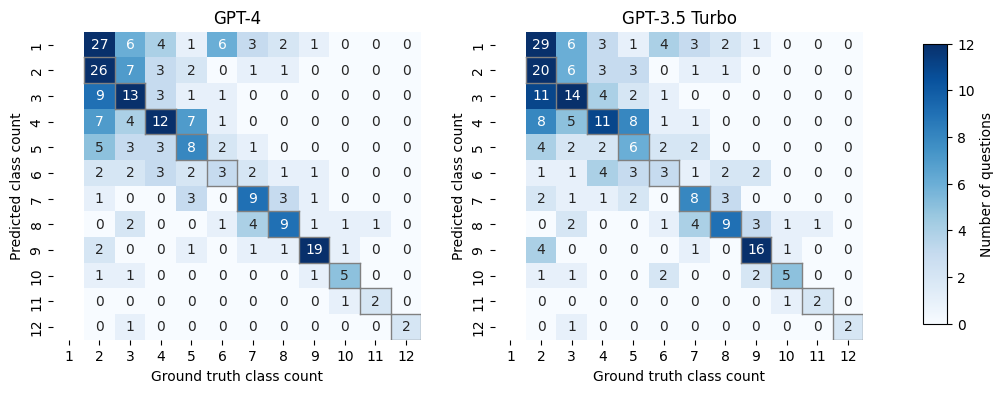

In [3]:
sites = ['Atlanta', 'Columbus', 'WashingtonDC',
         'Charlotte', 'Houston', 'Portland'] + ['Dallas', 'Seattle', 'Tucson']
checkpoints = ['gpt-4', 'gpt-35-turbo']
vmax = 12

# fig, axes = plt.subplots(1, len(checkpoints), figsize=(len(checkpoints) * 5, 5))
mats = []
for i, checkpoint in enumerate(checkpoints):
    mat = None
    for site in sites:
        try:
            mat_new = joblib.load(join(data.PROCESSED_DIR,
                                       f'classification_confusion_matrix_{site}_{checkpoint.split("/")[-1]}.pkl'))

            # sum mat_new with mat, make size bigger if needed
            if mat is None:
                mat = mat_new
            else:
                mold = mat.shape[0]
                mnew = mat_new.shape[0]
                if mold < mnew:
                    mat_temp = np.zeros((mnew, mnew))
                    mat_temp[:mold, :mold] = mat
                    mat = mat_temp + mat_new
                elif mold > mnew:
                    mat_temp = np.zeros((mold, mold))
                    mat_temp[:mnew, :mnew] = mat_new
                    mat = mat_temp + mat
                else:
                    mat = mat + mat_new
        except:
            print(
                f'Failed to load classification_confusion_matrix_{site}_{checkpoint.split("/")[-1]}.pkl')
    mat[:, 0] = np.nan
    mats.append(mat)


fig, axes = plt.subplots(
    1, len(checkpoints), figsize=(len(checkpoints) * 6, 4))
for i, checkpoint in enumerate(checkpoints):
    mat = mats[i]
    ax = axes[i]
    # mat = mat / np.sum(mat, axis=0)
    sns.heatmap(mat, fmt='g', cmap='Blues',
                vmax=vmax, ax=ax, cbar=False, annot=True)
    ax.set_xticks(np.arange(mat.shape[1]) +
                  0.5, np.arange(np.max(mat.shape[1])) + 1)
    ax.set_yticks(np.arange(mat.shape[0]) +
                  0.5, np.arange(np.max(mat.shape[0])) + 1)
    dvu.outline_diagonal(mat.shape, roffset=0.5,
                         coffset=0.5, skip_rows=[0], ax=ax)
    ax.set_ylabel('Predicted class count')
    ax.set_xlabel('Ground truth class count')
    ax.set_title(imodelsx.viz.CHECKPOINTS_RENAME_DICT.get(
        checkpoint, checkpoint))
    # plt.savefig(
    # f'../figs/classification_heatmap_{checkpoint.split("/")[-1]}.pdf', bbox_inches='tight')
    # plt.savefig(
    # f'../figs/classification_heatmap_{checkpoint.split("/")[-1]}.png', bbox_inches='tight', dpi=300)
    print(checkpoint, 'num questions', np.nansum(mat))
    print(checkpoint, 'num on diagonal', np.nansum(np.diag(mat)))
    print(checkpoint, 'frac on diagonal',
          np.nansum(np.diag(mat)) / np.nansum(mat))


# add colorbar separately
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(axes[0].collections[0], cax=cbar_ax, label='Number of questions')

plt.savefig('../figs/theme_classification.pdf', bbox_inches='tight')
plt.savefig('../figs/theme_classification.png',
            bbox_inches='tight', dpi=300)
plt.show()